In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import textwrap
import scipy
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt

In [5]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [4]:
device = "cuda:0"

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer size:  50066


In [6]:
checkpoint_path = "/auto/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
checkpoint_path

'/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/'

In [7]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

/auto/home/menuab/miniforge3/envs/cl11.8_t_4.37/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model loaded with embedding size of : 50066


In [3]:
data = pd.read_csv('/auto/home/menuab/code/computed_prop_for_Menua.csv', skiprows=[0], header=0)
data.head()

,Weight,SAS,CLogP,TPSA,QED,0
0,325.18,2.09,6.23,63.05,0.46,0.0
1,336.18,2.75,2.67,32.78,0.86,0.0
2,282.91,2.30,4.16,29.10,0.81,0.0
3,300.14,4.15,2.68,71.44,0.55,0.0
4,188.03,2.84,1.37,54.46,0.68,0.0


In [4]:
prior_distribution_samples = {}

In [8]:
data[data.QED==0]

,Weight,SAS,CLogP,TPSA,QED,0
725555,2237.57,8.48,-17.44,1194.00,0.0,0.0
2663277,1580.32,7.08,-6.43,748.48,0.0,0.0
2663278,1582.33,6.44,-5.16,742.82,0.0,0.0
4668115,1154.32,5.78,3.67,356.27,0.0,0.0
5785122,1155.33,5.70,4.01,353.44,0.0,0.0
...,...,...,...,...,...,...
77978944,1910.34,5.33,5.32,687.61,0.0,0.0
77983166,1773.66,7.59,7.82,532.63,0.0,0.0
77989279,1941.60,6.39,2.02,775.45,0.0,0.0
77997690,1907.15,8.05,10.44,487.02,0.0,0.0


In [65]:
data.describe()

,Weight,SAS,CLogP,TPSA,QED,0
count,7.818926e+07,7.818926e+07,7.818926e+07,7.818926e+07,7.818922e+07,7.819579e+07
mean,3.667522e+02,2.943413e+00,3.225748e+00,7.045073e+01,6.064342e-01,1.085480e-03
std,1.667999e+02,8.270422e-01,2.438680e+00,5.320051e+01,2.248175e-01,4.549508e-02
min,1.010000e+00,1.000000e+00,-2.186400e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.721500e+02,2.390000e+00,1.980000e+00,4.448000e+01,4.500000e-01,0.000000e+00
50%,3.391300e+02,2.780000e+00,3.090000e+00,6.443000e+01,6.500000e-01,0.000000e+00
75%,4.261800e+02,3.280000e+00,4.250000e+00,8.628000e+01,7.900000e-01,0.000000e+00
max,5.975075e+04,1.000000e+01,2.054800e+02,7.553400e+03,9.500000e-01,2.000000e+00


In [5]:
sas_dist = data.SAS.sample(n=100, random_state=42)

In [7]:
clogp_dist = data.CLogP.sample(n=100, random_state=42)

In [8]:
qed_dist = data.QED.sample(n=100, random_state=42)

In [9]:
weight_dist = data.Weight.sample(n=100, random_state=42)

In [10]:
TPSA_dist = data.TPSA.sample(n=100, random_state=42)

In [17]:
prior_distribution_samples["TPSA"]=TPSA_dist

In [103]:
prior_distribution_samples["TPSA"]=np.floor(TPSA_dist.values * 10)/10

In [18]:
with open("prior_distribution_samples","wb") as f:
    pickle.dump(prior_distribution_samples, f)

In [31]:
pubchem_stats_file = open("../stats_data/pubchem_stats.pkl", 'rb')
pubchem_stats = pickle.load(pubchem_stats_file)
pubchem_stats_file.close()

In [23]:
pubchem_stats = {}

In [137]:
with open("../stats_data/pubchem_stats.pkl","wb") as f:
    pickle.dump(pubchem_stats, f)

In [134]:
interval_index = pd.interval_range(start=-2, end=20, periods=100, closed='right')
# d=data.TPSA[(data.TPSA>0)&(data.TPSA<100)]
d=data.CLogP
frequency_data = pd.cut(d, bins=interval_index)
freq=frequency_data.value_counts().sort_index()

In [136]:
pubchem_stats["CLOGP"] = freq

In [130]:
freq

CLogP
(-2.0, -1.48]                                   248908
(-1.48, -0.96]                                  416044
(-0.96, -0.43999999999999995]                   737489
(-0.43999999999999995, 0.08000000000000007]    1325789
(0.08000000000000007, 0.6000000000000001]      2283255
                                                ...   
(47.4, 47.92]                                      213
(47.92, 48.440000000000005]                        187
(48.440000000000005, 48.96]                        202
(48.96, 49.480000000000004]                        199
(49.480000000000004, 50.0]                         157
Name: count, Length: 100, dtype: int64

(0.0, 10.0)

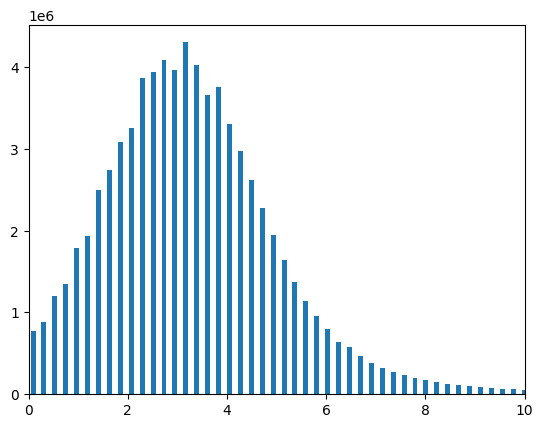

In [139]:
plt.bar([interval.mid for interval in freq.index], freq, width=.1)
plt.xlim(0,10)

<Axes: >

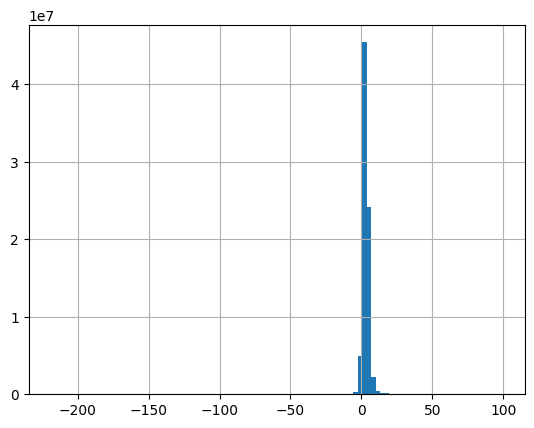

In [121]:
data.CLogP[data.CLogP<50].hist(bins=100)

In [66]:
interval_index_ = pd.interval_range(start=-200, end=200, periods=400, closed='right')
# d_=data.TPSA[(data.TPSA>0)&(data.TPSA<100)]
d_=data.CLOGP
frequency_data_ = pd.cut(d_, bins=interval_index_)
freq_=frequency_data_.value_counts().sort_index()

: 

: 

In [65]:
prior_distribution_samples["TPSA"] = freq_

(0.0, 100.0)

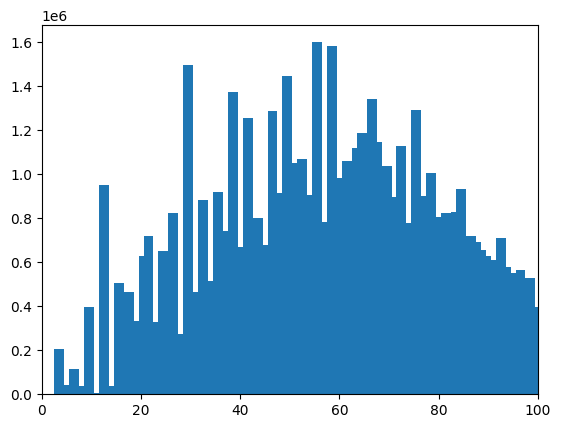

In [62]:
plt.bar([interval.mid for interval in freq_.index], freq_, width=2)
plt.xlim(0,100)

<Axes: >

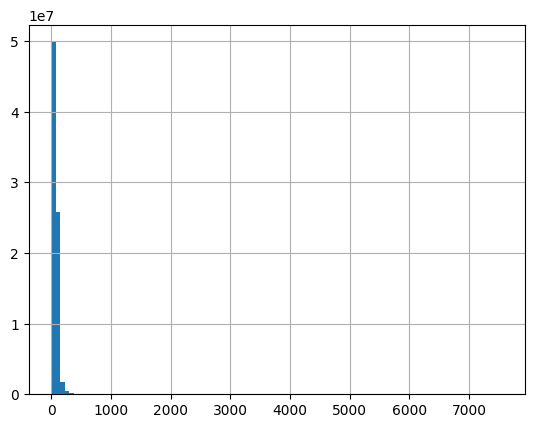

In [96]:
data.TPSA.hist(bins=100)

In [97]:
np.histogram(d, bins = interval_index)

TypeError: '<' not supported between instances of 'float' and 'pandas._libs.interval.Interval'

<Axes: >

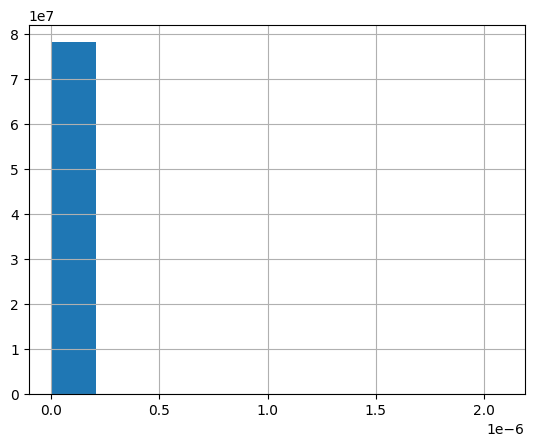

In [162]:
d.hist()

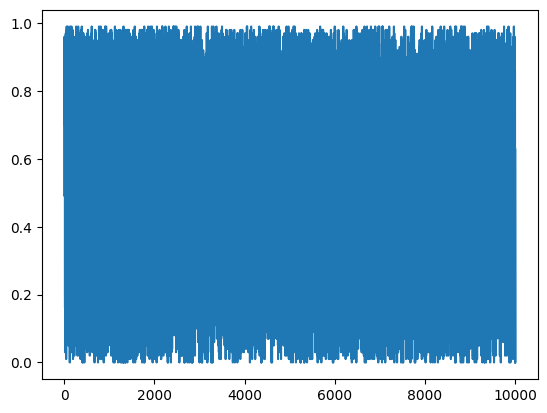

In [126]:
plt.plot(sampled_values);